# ML4SCI 2025 Tasks

**Common Test I. Multi-Class Classification**
<br>
Build a model for classifying the images into lenses using PyTorch or Keras. Pick the most appropriate approach and discuss your strategy.
<br>
<br>
This code implements a Lens Classification System using ResNet18 for classifying images into three classes: no, sphere, and vort.
<br>
My Approach:
<br>

1.   Mixed Precision Training to improve efficiency.
2.   Transfer Learning approach with ResNet18.
3.   Evaluates performance with AUC and ROC Curves.



## Breakdown to approach: 
* Transfer Learning with ResNet18, good for specially lens data with small or negligable diversity; saves time, give great accuracy, efficent.
* Mixed Precision Training for Faster training with reduced memory usage, No significant loss in model performance.
* Data Augmentation to reduce overfitting.
* Adam Optimizer: Combines the benefits of AdaGrad and RMSProp, adapting learning rates for each parameter. Works well for this task due to its efficiency and robustness.
* CrossEntropyLoss: Ideal for multi-class classification as it directly optimizes for class probabilities.

Also used approach alings with gaols of task as well as project's requirements and expectations. 

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import os

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

In [6]:
autocast = torch.amp.autocast
scaler = torch.amp.GradScaler()

Converts grayscale images to 3-channel format, like RGB.
<br>
Batch size = 128 and uses 2 workers for parallel data loading.

In [7]:
# Custom Dataset
class LensDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['no', 'sphere', 'vort']
        self.data = []

        for label, cls in enumerate(self.classes):
            cls_folder = os.path.join(root_dir, cls)
            for file_name in os.listdir(cls_folder):
                self.data.append((os.path.join(cls_folder, file_name), label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx]
        image = np.load(file_path).astype(np.float32)
        image = np.repeat(image[np.newaxis, :, :], 3, axis=0)  # Convert to 3 channels
        image = torch.tensor(image)
        if self.transform:
            image = self.transform(image.squeeze(1))
        return image, label

In [8]:
# Data Augmentation and Normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [10]:
# Load Datasets
train_dataset = LensDataset(root_dir='dataset/dataset/train', transform=transform)
val_dataset = LensDataset(root_dir='dataset/dataset/val', transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
]))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)

In [11]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 3)
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s]


In [12]:
# Optimizer and Loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Uses CrossEntropyLoss for multi-class classification and Adam Optimizer.
<br>
Implements Mixed Precision Training.

In [13]:
# Model Training
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')


Epoch [1/20], Loss: 0.9409
Epoch [2/20], Loss: 0.5254
Epoch [3/20], Loss: 0.3971
Epoch [4/20], Loss: 0.3271
Epoch [5/20], Loss: 0.2899
Epoch [6/20], Loss: 0.2633
Epoch [7/20], Loss: 0.2375
Epoch [8/20], Loss: 0.2199
Epoch [9/20], Loss: 0.2062
Epoch [10/20], Loss: 0.1895
Epoch [11/20], Loss: 0.1824
Epoch [12/20], Loss: 0.1739
Epoch [13/20], Loss: 0.1609
Epoch [14/20], Loss: 0.1577
Epoch [15/20], Loss: 0.1567
Epoch [16/20], Loss: 0.1470
Epoch [17/20], Loss: 0.1413
Epoch [18/20], Loss: 0.1344
Epoch [19/20], Loss: 0.1327
Epoch [20/20], Loss: 0.1256


Calculates AUC (Area Under Curve) Score to measure classification performance.
<br>
Plots ROC (Receiver Operating Characteristic) Curves for each class, showing the trade-off between true positive and false positive rates.

Validation AUC Score: 0.9910


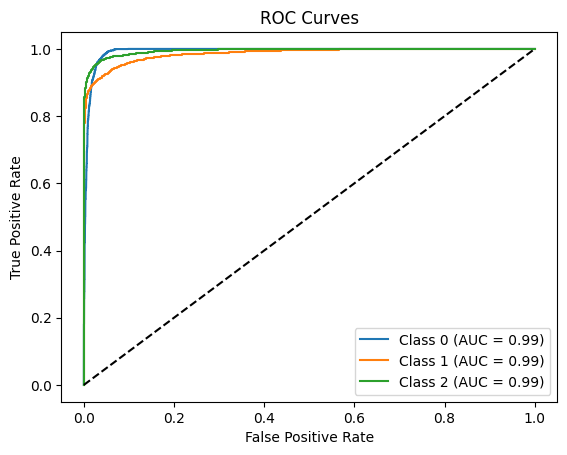

In [19]:
# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(probs)

# Calculate AUC Score
y_pred = np.array(y_pred)
auc_score = roc_auc_score(y_true, y_pred, multi_class='ovr')
print(f'Validation AUC Score: {auc_score:.4f}')

# Plot ROC Curves
fpr, tpr, roc_auc = {}, {}, {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve((np.array(y_true) == i).astype(int), y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()